In [1]:
!curl -s https://course.fast.ai/setup/colab | bash
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet nibabel pydicom medpy
!pip install --upgrade --quiet SimpleITK

mkdir: cannot create directory ‘/root’: Permission denied
mkdir: cannot create directory ‘/root’: Permission denied
ln: failed to create symbolic link ‘/content’: Permission denied
ln: failed to create symbolic link ‘/content’: Permission denied
Updating fastai...
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Done.


In [2]:
%pylab inline
import nibabel
import pydicom
import medpy
import SimpleITK
from fastai.vision import *
import os

import torch
#Save and load:
#torch.save(tensor, 'file.pt') and torch.load('file.pt')

Populating the interactive namespace from numpy and matplotlib


In [3]:
def sitk_show(img, title=None, margin=0.0, dpi=40):
    nda = SimpleITK.GetArrayFromImage(img)
    #spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    #extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    extent = (0, nda.shape[1], nda.shape[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

def load_vol(path, get_sitk=False):
    path = str(path) #correct for Posix Path types.
    img = SimpleITK.ReadImage(path)
    vol = SimpleITK.GetArrayFromImage(img)
    if get_sitk:
        return (vol, img)
    else:
        return vol

def basic_norm(arr):
    a_min = np.min(arr)
    a_max = np.max(arr)
    
    if a_min==a_max:
        #The image is blank
        return np.zeros(arr.shape)
    else:
        add_min = arr + a_min
        norm = add_min / a_max
        return norm
    
def vol_norm(vol):
    #Normalizes entire volume at once.
    return basic_norm(vol)

def slice_norm(vol):
    #Normalizes each slice
    return np.array([basic_norm(s) for s in vol])


## Gameplan:
<li>Get patient</li>
<li>Grab volumes and mask volume</li>
<li>Load volumes, split into images.</li>
<li>Normalize the images and stack.</li>
<li>Save!</li>

In [4]:
def grab_mhas(path):
    posix_path = pathlib.Path(path)
    files = np.array([[q for q in p.ls() if '.txt' not in str(q)] for p in pathlib.Path(path).ls()]).ravel()
    return ([f for f in files if 'OT' not in f.name], [f for f in files if 'OT' in f.name])

In [5]:
patients = []
for path, dirs, files in os.walk('./brats_2015/'):
    if 'Testing' not in path: #No Masks
        for d in dirs:
            if 'pat' in d and not 'brats_2013' in d: #Ignore data from the wrong year.
                patients.append(os.path.join(path,d))

patients[0]
xs, y = grab_mhas(patients[68])
vol, s_vol = load_vol(xs[0], get_sitk=True)


### Do we want to Bias Correct?


In [16]:
def bias_correct(img, levels=4, its_per_level=50):
    inputImage = SimpleITK.Cast(img, SimpleITK.sitkFloat32 )
    corrector = SimpleITK.N4BiasFieldCorrectionImageFilter()
    numberFittingLevels = levels
    corrector.SetMaximumNumberOfIterations( [ its_per_level ] *numberFittingLevels  )
    output = corrector.Execute(inputImage)
    return output

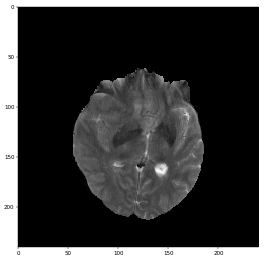

In [17]:
#Bias correction is possible, but would take a LONG time. (time per slice ~ 1 second)
sitk_show(bias_correct(s_vol[:,:,67]))

In [6]:
#This grabs all patient folders.
patients = []
for path, dirs, files in os.walk('./brats_2015/'):
    if 'Testing' not in path: #No Masks
        for d in dirs:
            if 'pat' in d and not 'brats_2013' in d: #Ignore data from the wrong year.
                patients.append(os.path.join(path,d))

In [7]:
patients[:10]

['./brats_2015/BRATS2015_Training/LGG/brats_tcia_pat141_0001',
 './brats_2015/BRATS2015_Training/LGG/brats_tcia_pat402_0001',
 './brats_2015/BRATS2015_Training/LGG/brats_tcia_pat480_0001',
 './brats_2015/BRATS2015_Training/LGG/brats_tcia_pat261_0001',
 './brats_2015/BRATS2015_Training/LGG/brats_tcia_pat175_0001',
 './brats_2015/BRATS2015_Training/LGG/brats_tcia_pat312_0001',
 './brats_2015/BRATS2015_Training/LGG/brats_tcia_pat449_0001',
 './brats_2015/BRATS2015_Training/LGG/brats_tcia_pat451_0001',
 './brats_2015/BRATS2015_Training/LGG/brats_tcia_pat410_0001',
 './brats_2015/BRATS2015_Training/LGG/brats_tcia_pat254_0001']

In [8]:
from tqdm import tqdm

In [9]:
for p in patients[:10]:
    xs, y = grab_mhas(p)

    #Grab patient ID from filename
    pid = xs[0].name.split('.')[-2]
    
    print(f'Grabbing PID {pid}')

Grabbing PID 35588
Grabbing PID 36249
Grabbing PID 41154
Grabbing PID 40941
Grabbing PID 40878
Grabbing PID 35984
Grabbing PID 36542
Grabbing PID 41141
Grabbing PID 41101
Grabbing PID 35841


In [10]:
xs, y = grab_mhas(patients[0])
xs

[PosixPath('brats_2015/BRATS2015_Training/LGG/brats_tcia_pat141_0001/VSD.Brain.XX.O.MR_T2.35588/VSD.Brain.XX.O.MR_T2.35588.mha'),
 PosixPath('brats_2015/BRATS2015_Training/LGG/brats_tcia_pat141_0001/VSD.Brain.XX.O.MR_Flair.35587/VSD.Brain.XX.O.MR_Flair.35587.mha'),
 PosixPath('brats_2015/BRATS2015_Training/LGG/brats_tcia_pat141_0001/VSD.Brain.XX.O.MR_T1c.35589/VSD.Brain.XX.O.MR_T1c.35589.mha'),
 PosixPath('brats_2015/BRATS2015_Training/LGG/brats_tcia_pat141_0001/VSD.Brain.XX.O.MR_T1.35590/VSD.Brain.XX.O.MR_T1.35590.mha')]

In [11]:
xs, y = grab_mhas(patients[100])
'_'.join(str(xs[0]).split('/')[3].split('_')[-2:])


'pat404_0001'

In [ ]:

'''
This should generate all the data we need.
'''
for p in patients:
    xs, y = grab_mhas(p)

    #Grab patient ID from filename
    pid = '_'.join(str(xs[0]).split('/')[3].split('_')[-2:])
    
    print(f'Grabbing PID {pid}')
    
    #Run slicewise normalization on each volume
    vols_list = [slice_norm(load_vol(x)) for x in xs]

    #Also load the mask volume
    mask_vol = load_vol(y[0])

    #Stick everything together
    vols_list.append(mask_vol)
    vols = np.array(vols_list)

    #Grab the number of slices.
    n_slices = vols.shape[1]


    #Modify output files here:
    for s in tqdm(range(n_slices)):
        a,b,c,d,m = vols[:,s,:,:]
        tensor = torch.from_numpy(np.stack([a,b,c,d], axis=2))
        #Specifically this one...
        torch.save(tensor,f'../brats_data/cleaned_brats/train/img/{pid}_{s}.pt')
        mask_tensor = torch.from_numpy(m)
        #And this one.
        torch.save(mask_tensor,f'../brats_data/cleaned_brats/train/mask/mask_{pid}_{s}.pt')

Grabbing PID pat141_0001


100%|██████████| 155/155 [00:00<00:00, 333.18it/s]


Grabbing PID pat402_0001


100%|██████████| 155/155 [00:00<00:00, 433.92it/s]


Grabbing PID pat480_0001


100%|██████████| 155/155 [00:00<00:00, 431.01it/s]


Grabbing PID pat261_0001


100%|██████████| 155/155 [00:00<00:00, 436.94it/s]


Grabbing PID pat175_0001


100%|██████████| 155/155 [00:00<00:00, 430.28it/s]


Grabbing PID pat312_0001


100%|██████████| 155/155 [00:00<00:00, 328.74it/s]


Grabbing PID pat449_0001


100%|██████████| 155/155 [00:00<00:00, 427.68it/s]


Grabbing PID pat451_0001


100%|██████████| 155/155 [00:00<00:00, 429.03it/s]


Grabbing PID pat410_0001


100%|██████████| 155/155 [00:00<00:00, 431.83it/s]


Grabbing PID pat254_0001


100%|██████████| 155/155 [00:00<00:00, 424.54it/s]


Grabbing PID pat325_0001


100%|██████████| 155/155 [00:00<00:00, 423.24it/s]


Grabbing PID pat249_0001


100%|██████████| 155/155 [00:00<00:00, 432.21it/s]


Grabbing PID pat298_0001


100%|██████████| 155/155 [00:00<00:00, 385.75it/s]


Grabbing PID pat442_0001


100%|██████████| 155/155 [00:00<00:00, 427.17it/s]


Grabbing PID pat177_0001


100%|██████████| 155/155 [00:00<00:00, 426.30it/s]


Grabbing PID pat354_0001


100%|██████████| 155/155 [00:00<00:00, 426.77it/s]


Grabbing PID pat428_0001


100%|██████████| 155/155 [00:00<00:00, 424.26it/s]


Grabbing PID pat103_0001


100%|██████████| 155/155 [00:00<00:00, 435.73it/s]


Grabbing PID pat101_0001


100%|██████████| 155/155 [00:00<00:00, 425.86it/s]


Grabbing PID pat351_0001


100%|██████████| 155/155 [00:00<00:00, 425.03it/s]


Grabbing PID pat202_0001


100%|██████████| 155/155 [00:00<00:00, 424.30it/s]


Grabbing PID pat109_0001


100%|██████████| 155/155 [00:00<00:00, 423.19it/s]


Grabbing PID pat307_0001


100%|██████████| 155/155 [00:00<00:00, 426.82it/s]


Grabbing PID pat152_0001


100%|██████████| 155/155 [00:00<00:00, 401.80it/s]


Grabbing PID pat462_0001


100%|██████████| 155/155 [00:00<00:00, 375.96it/s]


Grabbing PID pat413_0001


100%|██████████| 155/155 [00:00<00:00, 290.34it/s]


Grabbing PID pat470_0001


100%|██████████| 155/155 [00:00<00:00, 294.47it/s]


Grabbing PID pat130_0001


100%|██████████| 155/155 [00:00<00:00, 307.65it/s]


Grabbing PID pat255_0001


100%|██████████| 155/155 [00:00<00:00, 207.73it/s]


Grabbing PID pat490_0001


100%|██████████| 155/155 [00:00<00:00, 256.34it/s]


Grabbing PID pat282_0001


100%|██████████| 155/155 [00:00<00:00, 299.10it/s]


Grabbing PID pat466_0001


100%|██████████| 155/155 [00:00<00:00, 316.48it/s]


Grabbing PID pat387_0001


100%|██████████| 155/155 [00:00<00:00, 298.97it/s]


Grabbing PID pat483_0001


100%|██████████| 155/155 [00:00<00:00, 310.33it/s]


Grabbing PID pat276_0001


100%|██████████| 155/155 [00:00<00:00, 308.99it/s]


Grabbing PID pat408_0001


100%|██████████| 155/155 [00:00<00:00, 305.95it/s]


Grabbing PID pat266_0001


100%|██████████| 155/155 [00:00<00:00, 297.52it/s]


Grabbing PID pat299_0001


100%|██████████| 155/155 [00:00<00:00, 302.52it/s]


Grabbing PID pat330_0001


100%|██████████| 155/155 [00:00<00:00, 298.12it/s]


Grabbing PID pat420_0001


100%|██████████| 155/155 [00:00<00:00, 264.54it/s]


Grabbing PID pat346_0001


100%|██████████| 155/155 [00:00<00:00, 257.40it/s]


Grabbing PID pat493_0001


100%|██████████| 155/155 [00:00<00:00, 254.51it/s]


Grabbing PID pat393_0001


100%|██████████| 155/155 [00:00<00:00, 300.29it/s]


Grabbing PID pat241_0001


100%|██████████| 155/155 [00:00<00:00, 281.15it/s]


Grabbing PID pat171_0387


100%|██████████| 155/155 [00:00<00:00, 310.71it/s]


Grabbing PID pat399_0479


100%|██████████| 155/155 [00:00<00:00, 301.09it/s]


Grabbing PID pat319_0001


100%|██████████| 155/155 [00:00<00:00, 285.74it/s]


Grabbing PID pat230_0637


100%|██████████| 155/155 [00:00<00:00, 257.02it/s]


Grabbing PID pat280_0001


100%|██████████| 155/155 [00:00<00:00, 293.22it/s]


Grabbing PID pat171_1231


100%|██████████| 155/155 [00:00<00:00, 289.99it/s]


Grabbing PID pat260_0317


100%|██████████| 155/155 [00:00<00:00, 295.73it/s]


Grabbing PID pat164_0001


100%|██████████| 155/155 [00:00<00:00, 307.08it/s]


Grabbing PID pat260_0075


100%|██████████| 155/155 [00:00<00:00, 238.17it/s]


Grabbing PID pat153_0277


100%|██████████| 155/155 [00:00<00:00, 292.51it/s]


Grabbing PID pat135_0001


100%|██████████| 155/155 [00:00<00:00, 282.07it/s]


Grabbing PID pat473_0001


100%|██████████| 155/155 [00:00<00:00, 234.40it/s]


Grabbing PID pat399_0595


100%|██████████| 155/155 [00:00<00:00, 240.30it/s]


Grabbing PID pat478_0001


100%|██████████| 155/155 [00:00<00:00, 295.68it/s]


Grabbing PID pat409_0001


100%|██████████| 155/155 [00:00<00:00, 244.85it/s]


Grabbing PID pat274_0001


100%|██████████| 155/155 [00:00<00:00, 287.62it/s]


Grabbing PID pat260_0152


100%|██████████| 155/155 [00:00<00:00, 266.77it/s]


Grabbing PID pat399_0815


100%|██████████| 155/155 [00:00<00:00, 298.75it/s]


Grabbing PID pat173_0001


100%|██████████| 155/155 [00:00<00:00, 310.28it/s]


Grabbing PID pat328_0001


100%|██████████| 155/155 [00:00<00:00, 287.11it/s]


Grabbing PID pat463_0001


100%|██████████| 155/155 [00:00<00:00, 294.08it/s]


Grabbing PID pat290_0669


100%|██████████| 155/155 [00:00<00:00, 295.75it/s]


Grabbing PID pat411_0001


100%|██████████| 155/155 [00:00<00:00, 294.91it/s]


Grabbing PID pat343_0001


100%|██████████| 155/155 [00:00<00:00, 302.44it/s]


Grabbing PID pat153_0181


100%|██████████| 155/155 [00:00<00:00, 286.60it/s]


Grabbing PID pat322_0001


100%|██████████| 155/155 [00:00<00:00, 295.95it/s]


Grabbing PID pat396_0176


100%|██████████| 155/155 [00:00<00:00, 284.22it/s]


Grabbing PID pat474_0001


100%|██████████| 155/155 [00:00<00:00, 283.00it/s]


Grabbing PID pat235_0001


100%|██████████| 155/155 [00:00<00:00, 304.03it/s]


Grabbing PID pat105_0001


100%|██████████| 155/155 [00:00<00:00, 300.36it/s]


Grabbing PID pat399_0156


100%|██████████| 155/155 [00:00<00:00, 238.42it/s]


Grabbing PID pat121_0001


100%|██████████| 155/155 [00:00<00:00, 239.87it/s]


Grabbing PID pat260_0244


100%|██████████| 155/155 [00:00<00:00, 253.54it/s]


Grabbing PID pat439_0263


100%|██████████| 155/155 [00:00<00:00, 296.65it/s]


Grabbing PID pat186_0001


100%|██████████| 155/155 [00:00<00:00, 312.91it/s]


Grabbing PID pat374_0557


100%|██████████| 155/155 [00:00<00:00, 310.68it/s]


Grabbing PID pat226_0090


100%|██████████| 155/155 [00:00<00:00, 285.93it/s]


Grabbing PID pat331_0001


100%|██████████| 155/155 [00:00<00:00, 290.16it/s]


Grabbing PID pat437_0001


100%|██████████| 155/155 [00:00<00:00, 287.31it/s]


Grabbing PID pat230_0199


100%|██████████| 155/155 [00:00<00:00, 290.39it/s]


Grabbing PID pat117_0001


100%|██████████| 155/155 [00:00<00:00, 288.69it/s]


Grabbing PID pat265_0001


100%|██████████| 155/155 [00:00<00:00, 303.47it/s]


Grabbing PID pat290_0412


100%|██████████| 155/155 [00:00<00:00, 232.73it/s]


Grabbing PID pat309_0120


100%|██████████| 155/155 [00:00<00:00, 300.68it/s]


Grabbing PID pat425_0001


100%|██████████| 155/155 [00:00<00:00, 292.38it/s]


Grabbing PID pat260_0001


100%|██████████| 155/155 [00:00<00:00, 222.54it/s]


Grabbing PID pat199_0001


100%|██████████| 155/155 [00:00<00:00, 238.49it/s]


Grabbing PID pat439_0333


100%|██████████| 155/155 [00:00<00:00, 301.68it/s]


Grabbing PID pat447_0122


100%|██████████| 155/155 [00:00<00:00, 284.09it/s]


Grabbing PID pat165_0001


100%|██████████| 155/155 [00:00<00:00, 306.13it/s]


Grabbing PID pat149_0001


100%|██████████| 155/155 [00:00<00:00, 276.03it/s]


Grabbing PID pat417_0019


100%|██████████| 155/155 [00:00<00:00, 285.82it/s]


Grabbing PID pat138_0001


100%|██████████| 155/155 [00:00<00:00, 286.06it/s]


Grabbing PID pat156_0001


100%|██████████| 155/155 [00:00<00:00, 225.74it/s]


Grabbing PID pat280_0003


100%|██████████| 155/155 [00:00<00:00, 298.54it/s]


Grabbing PID pat401_0001


100%|██████████| 155/155 [00:00<00:00, 291.74it/s]


Grabbing PID pat404_0001


100%|██████████| 155/155 [00:00<00:00, 297.84it/s]


Grabbing PID pat111_0001


100%|██████████| 155/155 [00:00<00:00, 249.68it/s]


Grabbing PID pat399_0527


100%|██████████| 155/155 [00:00<00:00, 258.63it/s]


Grabbing PID pat153_0294


100%|██████████| 155/155 [00:00<00:00, 199.92it/s]


Grabbing PID pat171_0780


100%|██████████| 155/155 [00:00<00:00, 307.70it/s]


Grabbing PID pat444_0033


100%|██████████| 155/155 [00:00<00:00, 288.45it/s]


Grabbing PID pat374_0356


100%|██████████| 155/155 [00:00<00:00, 304.47it/s]


Grabbing PID pat374_1426


100%|██████████| 155/155 [00:00<00:00, 284.99it/s]


Grabbing PID pat309_0462


100%|██████████| 155/155 [00:00<00:00, 298.76it/s]


Grabbing PID pat335_0001


100%|██████████| 155/155 [00:00<00:00, 308.03it/s]


Grabbing PID pat193_0002


100%|██████████| 155/155 [00:00<00:00, 288.37it/s]


Grabbing PID pat439_0360


100%|██████████| 155/155 [00:00<00:00, 285.45it/s]


Grabbing PID pat399_0217


100%|██████████| 155/155 [00:00<00:00, 312.32it/s]


Grabbing PID pat226_0001


100%|██████████| 155/155 [00:00<00:00, 300.34it/s]


Grabbing PID pat374_0801


100%|██████████| 155/155 [00:00<00:00, 251.31it/s]


Grabbing PID pat153_0109


100%|██████████| 155/155 [00:00<00:00, 294.54it/s]


Grabbing PID pat283_0001


100%|██████████| 155/155 [00:00<00:00, 296.59it/s]


Grabbing PID pat392_0340


100%|██████████| 155/155 [00:00<00:00, 299.95it/s]


Grabbing PID pat190_0001


100%|██████████| 155/155 [00:00<00:00, 287.26it/s]


Grabbing PID pat321_0001


100%|██████████| 155/155 [00:00<00:00, 292.61it/s]


Grabbing PID pat309_0243


100%|██████████| 155/155 [00:00<00:00, 279.24it/s]


Grabbing PID pat377_0640


100%|██████████| 155/155 [00:00<00:00, 292.54it/s]


Grabbing PID pat192_0001


100%|██████████| 155/155 [00:00<00:00, 279.84it/s]


Grabbing PID pat372_0001


100%|██████████| 155/155 [00:00<00:00, 236.42it/s]


Grabbing PID pat171_1126


100%|██████████| 155/155 [00:00<00:00, 277.06it/s]


Grabbing PID pat314_0150


100%|██████████| 155/155 [00:00<00:00, 279.56it/s]


Grabbing PID pat198_0001


100%|██████████| 155/155 [00:00<00:00, 295.50it/s]


Grabbing PID pat469_0001


100%|██████████| 155/155 [00:00<00:00, 283.49it/s]


Grabbing PID pat447_0313


100%|██████████| 155/155 [00:00<00:00, 295.24it/s]


Grabbing PID pat184_0001


100%|██████████| 155/155 [00:00<00:00, 283.82it/s]


Grabbing PID pat242_0001


100%|██████████| 155/155 [00:00<00:00, 295.68it/s]


Grabbing PID pat118_0001


100%|██████████| 155/155 [00:00<00:00, 281.10it/s]


Grabbing PID pat444_0104


100%|██████████| 155/155 [00:00<00:00, 278.50it/s]


Grabbing PID pat429_0001


100%|██████████| 155/155 [00:00<00:00, 293.02it/s]


Grabbing PID pat258_0001


100%|██████████| 155/155 [00:00<00:00, 286.69it/s]


Grabbing PID pat396_0217


100%|██████████| 155/155 [00:00<00:00, 230.83it/s]


Grabbing PID pat314_0016


100%|██████████| 155/155 [00:00<00:00, 287.64it/s]


Grabbing PID pat399_0002


100%|██████████| 155/155 [00:00<00:00, 277.95it/s]


Grabbing PID pat151_0001


100%|██████████| 155/155 [00:00<00:00, 308.81it/s]


Grabbing PID pat147_0001


100%|██████████| 155/155 [00:00<00:00, 306.47it/s]


Grabbing PID pat167_0001


100%|██████████| 155/155 [00:00<00:00, 299.05it/s]


Grabbing PID pat396_0294


100%|██████████| 155/155 [00:00<00:00, 295.45it/s]


Grabbing PID pat234_0001


100%|██████████| 155/155 [00:00<00:00, 194.17it/s]


Grabbing PID pat171_0001


100%|██████████| 155/155 [00:00<00:00, 294.27it/s]


Grabbing PID pat218_0001


100%|██████████| 155/155 [00:00<00:00, 234.14it/s]


Grabbing PID pat257_0001


100%|██████████| 155/155 [00:00<00:00, 246.29it/s]


Grabbing PID pat201_0001


100%|██████████| 155/155 [00:00<00:00, 295.69it/s]


Grabbing PID pat479_0001


100%|██████████| 155/155 [00:00<00:00, 248.53it/s]


Grabbing PID pat417_0001


100%|██████████| 155/155 [00:00<00:00, 296.50it/s]


Grabbing PID pat168_0001


100%|██████████| 155/155 [00:00<00:00, 295.45it/s]


Grabbing PID pat290_0001


100%|██████████| 155/155 [00:00<00:00, 291.59it/s]


Grabbing PID pat432_0001


100%|██████████| 155/155 [00:00<00:00, 289.30it/s]


Grabbing PID pat205_0001


100%|██████████| 155/155 [00:00<00:00, 282.40it/s]


Grabbing PID pat247_0001


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in true_divide
100%|██████████| 155/155 [00:00<00:00, 293.02it/s]


Grabbing PID pat124_0003


100%|██████████| 155/155 [00:00<00:00, 299.37it/s]


Grabbing PID pat455_0001


100%|██████████| 155/155 [00:00<00:00, 293.53it/s]


Grabbing PID pat444_0038


100%|██████████| 155/155 [00:00<00:00, 292.66it/s]


Grabbing PID pat260_0129


100%|██████████| 155/155 [00:00<00:00, 289.57it/s]


Grabbing PID pat491_0001


100%|██████████| 155/155 [00:00<00:00, 288.50it/s]


Grabbing PID pat370_1470


100%|██████████| 155/155 [00:00<00:00, 286.95it/s]


Grabbing PID pat113_0001


100%|██████████| 155/155 [00:00<00:00, 294.39it/s]


Grabbing PID pat374_1165


100%|██████████| 155/155 [00:00<00:00, 283.52it/s]


Grabbing PID pat171_0950


100%|██████████| 155/155 [00:00<00:00, 295.43it/s]


Grabbing PID pat157_0001


100%|██████████| 155/155 [00:00<00:00, 291.78it/s]


Grabbing PID pat179_0001


100%|██████████| 155/155 [00:00<00:00, 306.30it/s]


Grabbing PID pat277_0001


100%|██████████| 155/155 [00:00<00:00, 282.07it/s]


Grabbing PID pat211_0001


100%|██████████| 155/155 [00:00<00:00, 300.78it/s]


Grabbing PID pat150_0001


100%|██████████| 155/155 [00:00<00:00, 163.10it/s]


Grabbing PID pat396_0139


100%|██████████| 155/155 [00:00<00:00, 291.45it/s]


Grabbing PID pat468_0001


100%|██████████| 155/155 [00:00<00:00, 288.39it/s]


Grabbing PID pat419_0001


100%|██████████| 155/155 [00:00<00:00, 299.33it/s]


Grabbing PID pat222_0304


100%|██████████| 155/155 [00:00<00:00, 297.00it/s]


Grabbing PID pat290_0580


100%|██████████| 155/155 [00:00<00:00, 282.10it/s]


Grabbing PID pat120_0001


100%|██████████| 155/155 [00:00<00:00, 298.55it/s]


Grabbing PID pat171_0200


100%|██████████| 155/155 [00:00<00:00, 276.06it/s]


Grabbing PID pat370_0383


100%|██████████| 155/155 [00:00<00:00, 287.98it/s]


Grabbing PID pat296_0001


100%|██████████| 155/155 [00:00<00:00, 306.04it/s]


Grabbing PID pat180_0001


100%|██████████| 155/155 [00:00<00:00, 275.63it/s]


Grabbing PID pat391_0002


100%|██████████| 155/155 [00:00<00:00, 230.64it/s]


Grabbing PID pat203_0001


100%|██████████| 155/155 [00:00<00:00, 274.37it/s]


Grabbing PID pat361_0001


100%|██████████| 155/155 [00:00<00:00, 309.04it/s]


Grabbing PID pat374_0909


100%|██████████| 155/155 [00:00<00:00, 291.94it/s]


Grabbing PID pat374_0001


100%|██████████| 155/155 [00:00<00:00, 235.15it/s]


Grabbing PID pat390_0001


100%|██████████| 155/155 [00:00<00:00, 285.62it/s]


Grabbing PID pat309_0203


100%|██████████| 155/155 [00:00<00:00, 281.02it/s]


Grabbing PID pat231_0001


100%|██████████| 155/155 [00:00<00:00, 280.05it/s]


Grabbing PID pat375_0001


100%|██████████| 155/155 [00:00<00:00, 278.58it/s]


Grabbing PID pat471_0001


100%|██████████| 155/155 [00:00<00:00, 202.84it/s]


Grabbing PID pat198_0283


100%|██████████| 155/155 [00:00<00:00, 274.66it/s]


Grabbing PID pat290_0305


100%|██████████| 155/155 [00:00<00:00, 269.23it/s]


Grabbing PID pat183_0001


100%|██████████| 155/155 [00:00<00:00, 292.60it/s]


Grabbing PID pat131_0001


100%|██████████| 155/155 [00:00<00:00, 287.85it/s]


Grabbing PID pat309_0001


100%|██████████| 155/155 [00:00<00:00, 293.12it/s]


Grabbing PID pat448_0001


100%|██████████| 155/155 [00:00<00:00, 282.10it/s]


Grabbing PID pat399_0417


100%|██████████| 155/155 [00:00<00:00, 282.98it/s]


Grabbing PID pat332_0001


100%|██████████| 155/155 [00:00<00:00, 285.20it/s]


Grabbing PID pat498_0001


100%|██████████| 155/155 [00:00<00:00, 205.35it/s]


Grabbing PID pat178_0002


100%|██████████| 155/155 [00:00<00:00, 257.13it/s]


Grabbing PID pat153_0165


In [14]:
len(os.listdir('test_dump/'))

310

In [56]:
np.array([vol1 (3D -> slices, h, w), vol2, vol3, vol4, mask]) -> 4D: (vol, slice, h, w) [0, : : : ]

torch.Size([240, 240, 4])

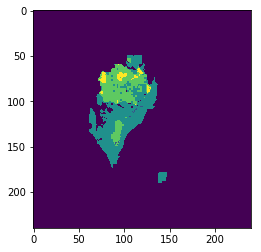

In [33]:
plt.imshow(vols[4,70,:,:])

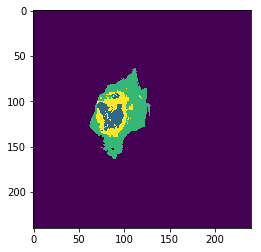

In [35]:
plt.imshow(torch.load('./test_dump/mask_pat175_0001_80.pt'))

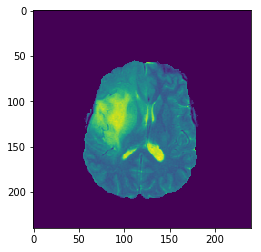

In [36]:
plt.imshow(torch.load('./test_dump/pat175_0001_80.pt')[:,:,2])